# Deliverable 6.2 - Robust Tube MPC Position Controller (x-,y-axis and roll)

Three nominal MPC controllers are designed for the **x-position, y_position and roll angle** subsystems to drive the rocket from x=3m, y=2m and roll=30° to x=1m, y=0m, roll=0°. These controllers are then merged with the robust tube-based MPC controller for the vertical z-dynamics using `MPCLandControl` architecture.

In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

## MPC for x_Position Control (`MPCControl_x`)
### Cost Function Design
The MPC cost function is quadratic and consist of:
* Stage cost for tracking the reference state
* Control effort penalty
* Slack variable penalty for soft constraints
* Terminal cost derived from the discrete-time Algebraic Riccati Equation (DARE)

The terminal cost matrix $P$ is computed via the DARE

### Reference Tracking and Trim Formulation
The controller is implemented in deviation coordinates around the trim condition:

$$
\Delta x_k = x_k - x_s, \quad \Delta u_k = u_k - u_s
$$

This guarantis that the MPC operates around a locally valid linearization and ensures consistency with the nonlinear simulation

## MPC for y_Position Control (`MPCControl_y`)
The structure of the code is the same as the x_position controller

## MPC for Roll Angle Control (`MPCControl_roll`)
Also in this case, the structure is the same as the x- and y-position controller

## Integration with the Robust z-Controller
The three nominal MPC controllers (x, y, roll) are merged with the robust tube-based MPC controller for the z-direction using the `MPCLandControl`class.

In [2]:
import time
from LandMPC.MPCLandControl import MPCLandControl
from src.rocket import Rocket, perturb_rocket
from src.pos_rocket_vis import *

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir,"rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

In [ ]:
sim_time = 15.0 # simulation length in seconds
x0 = np.array([0., 0., 0.,
               0., 0., np.deg2rad(30),
               0., 0., 0.,
               3., 2., 10.]) # w, phi, v, p
x_ref = np.array([0., 0., 0.,
                  0., 0., 0.,
                  0., 0., 0.,
                  1., 0., 3.])
xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)
A, B = rocket.linearize(xs, us)

# MPC parameters
H = 2.5
# Merge four linear mpc
mpc = MPCLandControl().new_controller(rocket, Ts, H, x_ref=x_ref)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]
Setting up MPC_y: N=40, Ts=0.05
MPC_y setup complete
[Tube MPC z] N=40, Ts=0.05, xs[z]=3.00, us=56.67
  LQR K=[-19.55993102 -25.86666986], |eig|max=0.915
  RPI bounds: vz∈[-0.713,0.696], z∈[-0.584,0.195]
  Tightened: Δvz∈[-19.29,9.30], Δz∈[-2.42,19.81], ΔPavg∈[-8.38,4.65]
  MPC setup complete.


## Closed-Loop simulation

Simulating time 0.00
MPC failed: MPC infeasible or failed: infeasible
MPC failed: MPC infeasible or failed: infeasible
MPC failed: MPC infeasible or failed: infeasible
MPC failed: MPC infeasible or failed: infeasible
MPC failed: MPC infeasible or failed: infeasible

 State alpha violation: 0.26 > 0.17, MPC failed: MPC infeasible or failed: infeasible

 State alpha violation: 0.36 > 0.17, MPC failed: MPC infeasible or failed: infeasible

 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.44 > 0.17, MPC failed: MPC infeasible or failed: infeasible

 State beta violation: -0.24 < -0.17, 
 State alpha violation: 0.49 > 0.17, MPC failed: MPC infeasible or failed: infeasible

 State beta violation: -0.28 < -0.17, 
 State alpha violation: 0.50 > 0.17, MPC failed: MPC infeasible or failed: infeasible

 State beta violation: -0.32 < -0.17, 
 State alpha violation: 0.48 > 0.17, MPC failed: MPC infeasible or failed: infeasible

 State beta violation: -0.34 < -0.17, 
 State alpha vio

/opt/anaconda3/envs/mpc2025/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


MPC failed: MPC infeasible or failed: user_limit
MPC failed: MPC infeasible or failed: user_limit

 State alpha violation: -0.22 < -0.17, MPC failed: MPC infeasible or failed: user_limit

 State alpha violation: -0.24 < -0.17, MPC failed: MPC infeasible or failed: user_limit

 State alpha violation: -0.20 < -0.17, 
 State beta violation: 0.18 > 0.17, MPC failed: MPC infeasible or failed: user_limit

 State beta violation: 0.20 > 0.17, 
 State beta violation: 0.19 > 0.17, 
 State beta violation: 0.18 > 0.17, 
 State beta violation: 0.18 > 0.17, 
 State beta violation: 0.18 > 0.17, 
 State beta violation: 0.18 > 0.17, 
 State beta violation: 0.18 > 0.17, 
 State beta violation: 0.18 > 0.17, 
 State beta violation: 0.18 > 0.17, 
 State beta violation: 0.18 > 0.17, 
 State beta violation: 0.18 > 0.17, Simulating time 2.00

 State beta violation: 0.17 > 0.17, Simulating time 3.00
Simulating time 4.00
Simulating time 5.00
Simulating time 6.00
Simulating time 7.00
Simulating time 8.00
Simulat

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

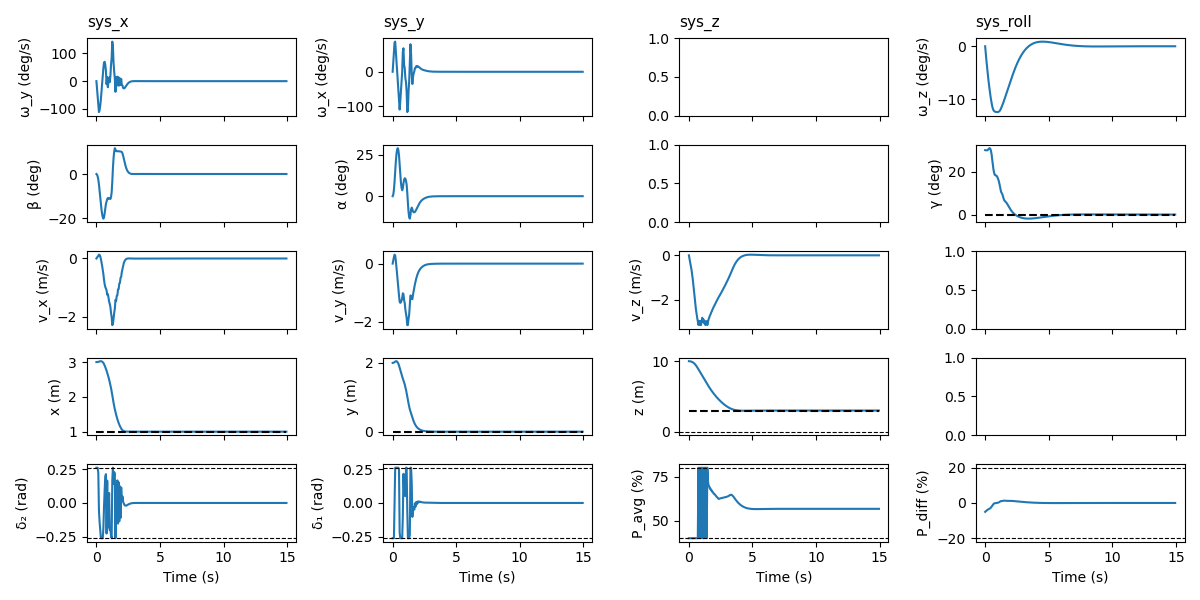

In [4]:
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(mpc, sim_time, H, x0)
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs)